Titanic data set, https://www.geeksforgeeks.org/machine-learning/titanic-survival-prediction-using-ml/

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

print(f'There are {train.shape[0]} rows and {train.shape[1]} columns')

There are 891 rows and 12 columns


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# null values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

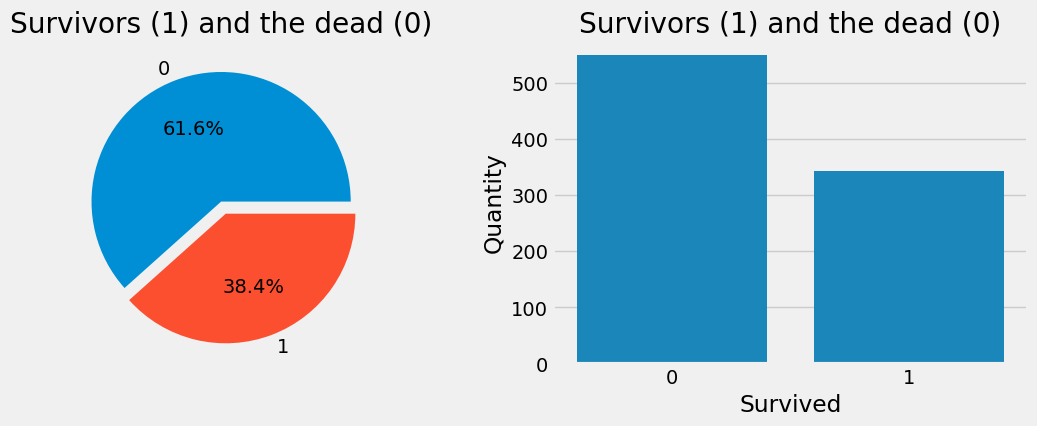

In [5]:
# visualize some of the data
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train['Survived'].value_counts().plot.pie(
    explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=False)
ax[0].set_title('Survivors (1) and the dead (0)')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data=train, ax=ax[1])
ax[1].set_ylabel('Quantity')
ax[1].set_title('Survivors (1) and the dead (0)')
plt.savefig('../results/figures/survivalPie.png', dpi=300, bbox_inches='tight')

plt.show()

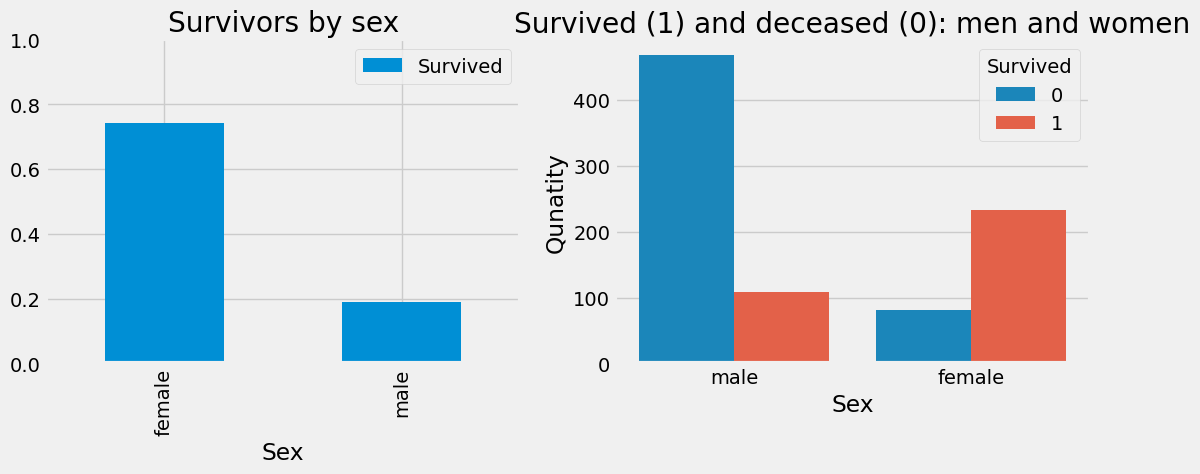

In [6]:
# impact of sex on survival rate
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survivors by sex')
ax[0].set_ylim([0.0, 1.0])
sns.countplot(x='Sex', hue='Survived', data=train, ax=ax[1])
ax[1].set_ylabel('Qunatity')
ax[1].set_title('Survived (1) and deceased (0): men and women')
plt.savefig('../results/figures/survivalBar.png', dpi=300, bbox_inches='tight')

plt.show()

In [7]:
# optimze data by first removing redundant data, and data unlikely to be useful
train = train.drop(['Cabin'], axis=1)
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Cabin'], axis=1)
test = test.drop(['Ticket'], axis=1)

In [8]:
# replace missing values with an S
train = train.fillna({'Embarked': 'S'})

In [9]:
# sort age groups to reduce the number of categories such that the dataset is categorical
train['Age'] = train['Age'].fillna(-0.5)
test['Age'] = test['Age'].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train['Age'], bins, labels=labels)
test['AgeGroup'] = pd.cut(test['Age'], bins, labels=labels)

In [10]:
# categorize test and train set into equal number of classes and assign numerical value to the title
combine = [train, test]

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
                                                 'Don', 'Dr', 'Major',
                                                 'Rev', 'Jonkheer', 'Dona'],
                                                'Rare')

    dataset['Title'] = dataset['Title'].replace(
        ['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# map titles to numerical values
title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Royal':5, 'Rare':6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

# fill in missing age data
mr_age = train[train["Title"] == 1]["AgeGroup"].mode()  # Young Adult
miss_age = train[train["Title"] == 2]["AgeGroup"].mode()  # Student
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode()  # Adult
master_age = train[train["Title"] == 4]["AgeGroup"].mode()  # Baby
royal_age = train[train["Title"] == 5]["AgeGroup"].mode()  # Adult
rare_age = train[train["Title"] == 6]["AgeGroup"].mode()  # Adult

age_title_mapping = {1: "Young Adult", 2: "Student",
                     3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

for x in range(len(train["AgeGroup"])):
    if train["AgeGroup"][x] == "Unknown":
        train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]

for x in range(len(test["AgeGroup"])):
    if test["AgeGroup"][x] == "Unknown":
        test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]

# add a numerical value to each category, drop age feature
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3,
               'Student': 4, 'Young Adult': 5, 'Adult': 6, 
               'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

train.head()

train = train.drop(['Age'], axis=1)
test = test.drop(['Age'], axis=1)
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)


sex_mapping = {'male':0, 'female':1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

embarked_mapping = {'S':1, 'C':2, 'Q':3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

In [11]:
for x in range(len(test['Fare'])):
    if pd.isnull(test['Fare'][x]):
        pclass = test['Pclass'][x]
        test['Fare'][x] = round(train[train['Pclass'] == pclass]['Fare'].mean(), 4)

# map fare values onto numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4, labels=[1,2,3,4])
test['FareBand'] = pd.qcut(test['Fare'], 4, labels=[1,2,3,4])

# drop fare values
train = train.drop(['Fare'], axis=1)
test = test.drop(['Fare'], axis=1)

In [12]:
# use a random forest to predict model to predict survival
from sklearn.model_selection import train_test_split

# drop Survived and PassengerId
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train['Survived']
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size=0.2, random_state=0)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

randomforest = RandomForestClassifier()

# fit training data along with its output
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)

# find the accuracy score of the model
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

84.92


In [14]:
ids = test['PassengerId']
predictions = randomforest.predict(test.drop('PassengerId', asix=1))

# set the output as a dateframe
output = pd.DateFrame({'PassengerId': ids, 'Survived': predictions})

TypeError: DataFrame.drop() got an unexpected keyword argument 'asix'